# German_Credit_Risk_Prediction

Dataset link: https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

In [17]:
import warnings
warnings.filterwarnings(action = 'ignore')

# from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

#Import classification methods and support methods
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Import Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

SEED = 42

read the dataset,and take a look for the output

In [19]:
df = pd.read_csv('data.csv', sep=';', header=None)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2


Since the original dataset lacked a header, I must first rename all the columns. The generated dataset is as follows, starting from the description provided on the original page:

In [20]:
df.columns = ['checkingAccount','duration','creditHistory', 'purpose', 'creditAmount','savingsAcc','employmentTime', 'installmentPercIncome', 
              'status', 'otherFin', 'timeResidence', 'property' ,'age', 'otherInstallPlans' ,'housing' ,'numCredits', 'job', 'numOfMant', 'phone', 'foreignWorker', 'risk']
df['risk'] = df['risk'] - 1 #(0 = Good, 1 = Bad)
df.head(2)

,checkingAccount,duration,creditHistory,purpose,creditAmount,savingsAcc,employmentTime,installmentPercIncome,status,otherFin,...,property,age,otherInstallPlans,housing,numCredits,job,numOfMant,phone,foreignWorker,risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1


The dataset is said not to support null values in the description.

In [21]:
df.isnull().values.any()

False

In [22]:
df['risk'] = df['risk'].astype('category')

Numerical Data: 
Count up all of the occurrences; average across all cases; average of all incidents; return the lowest value with Min; the percentile levels for each attribute are 25%, 50%, and 75%; max will return the highest value.

In [23]:
df.describe()

,duration,creditAmount,installmentPercIncome,timeResidence,age,numCredits,numOfMant
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Data are evenly distributed across the interval of values, and duration doesn't have any odd values. Given the high standard deviation of CreditAmount, one strategy for spotting potentially incorrect data is to show it by grouping for Purpose. Age ranges from 19 years to 75 years, thus it is exactly in line with expectations.

Text(0.5, 1.0, 'Correlation Heatmap')

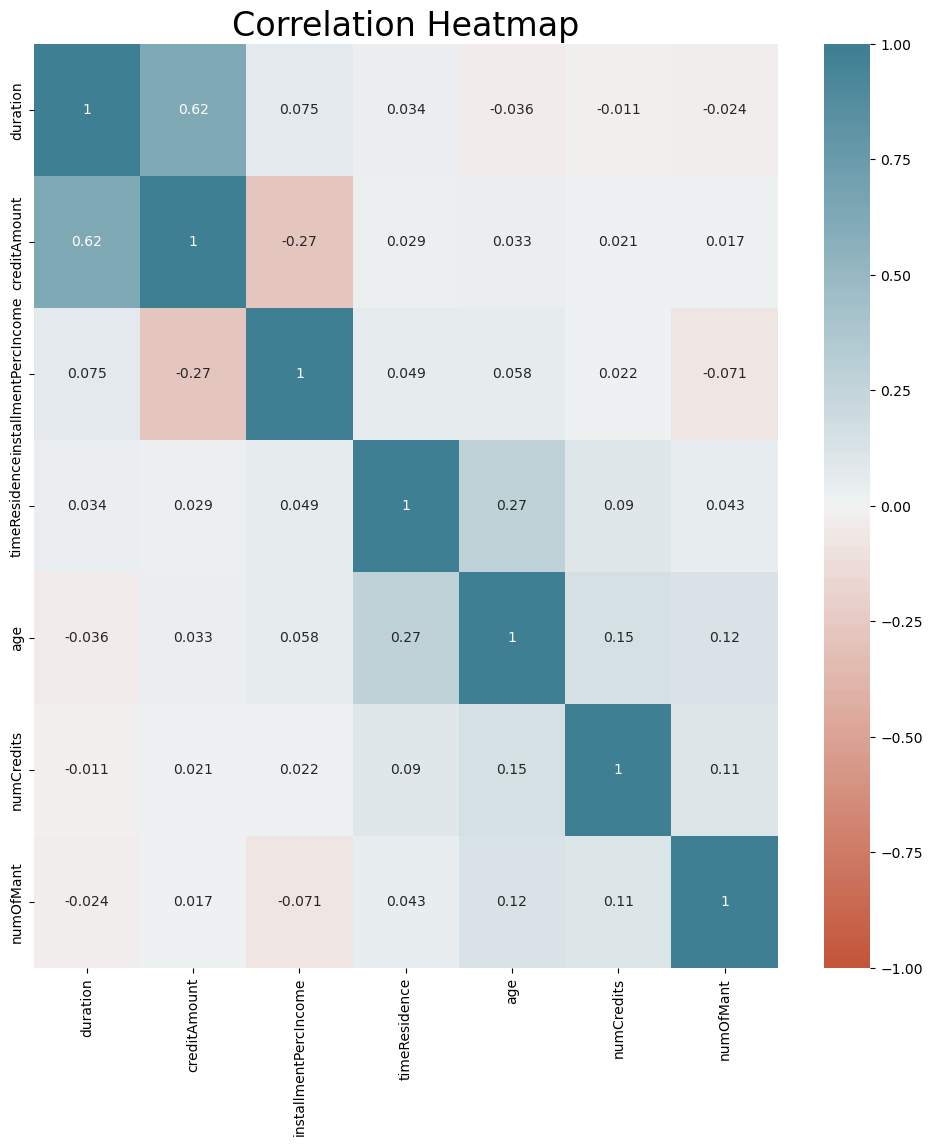

In [24]:
numerical = df.select_dtypes(include=['int64'])
numerical = (numerical-numerical.mean())/numerical.std()
corr = numerical.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, annot = True, 
            vmin = -1, vmax = 1, center = 0,
            cmap = sns.diverging_palette(20, 220, n = 200))
plt.title('Correlation Heatmap', fontsize = 24)

According to the correlation map, there are no other significant correlations, and duration and creditAmount have the highest correlation.

Categorical Data: It is possible to analyze categorical data using a plot of frequencies.

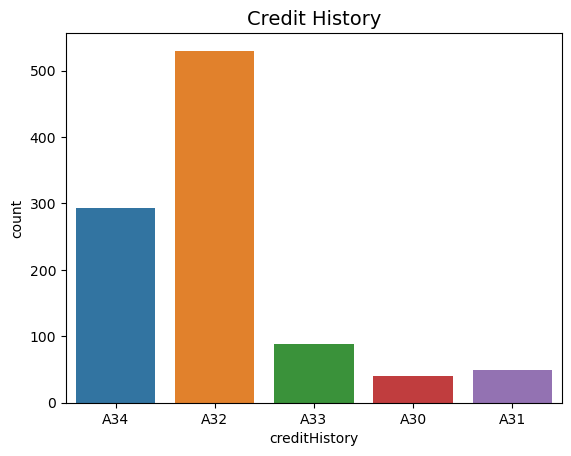

In [25]:
sns.countplot('creditHistory', data=df)
plt.title('Credit History', fontsize=14)
plt.show()

A30: No credit taken; all credit returned as required
A31: This bank has fully repaid all of its debts.
A32: Current Credits Fully Repaid to Date
A33: a historical payment delay A34: an important account or other existing credits

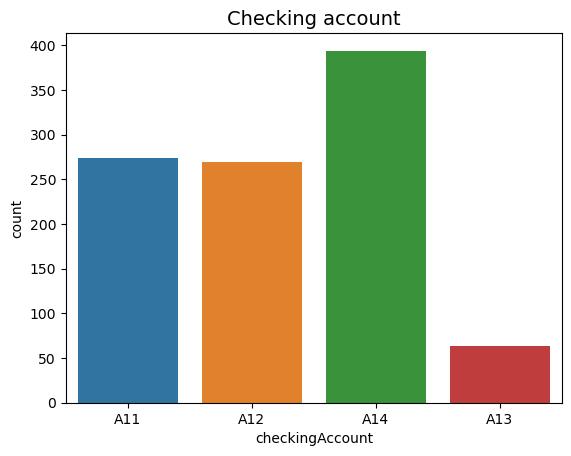

In [26]:
sns.countplot('checkingAccount', data=df)
plt.title('Checking account', fontsize=14)
plt.show()

A11 : ... < 0 DM
A12 : 0 <= ... < 200 DM
A13 : ... >= 200 DM / salary assignments for at least 1 year
A14 : no checking account

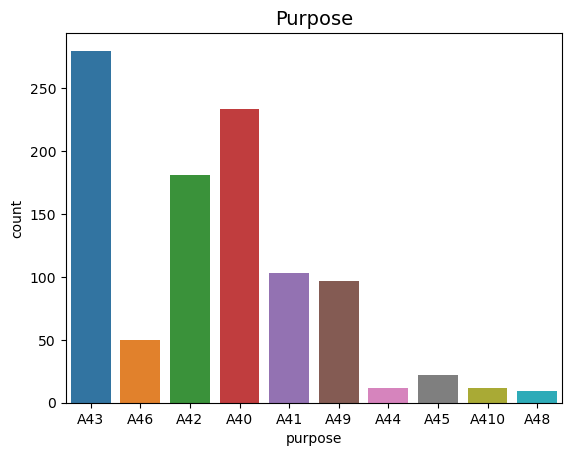

In [27]:
sns.countplot('purpose', data=df)
plt.title('Purpose', fontsize=14)
plt.show()

A40 : car (new)
A41 : car (used)
A42 : furniture/equipment
A43 : radio/television
A44 : domestic appliances
A45 : repairs
A46 : education
A47 : (vacation - does not exist?)
A48 : retraining
A49 : business
A410 : others

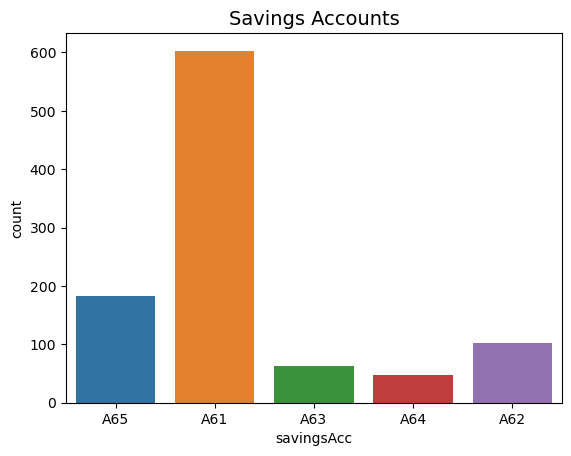

In [28]:
sns.countplot('savingsAcc', data=df)
plt.title('Savings Accounts', fontsize=14)
plt.show()

A61 : ... < 100 DM
A62 : 100 <= ... < 500 DM
A63 : 500 <= ... < 1000 DM
A64 : .. >= 1000 DM
A65 : unknown/ no savings account

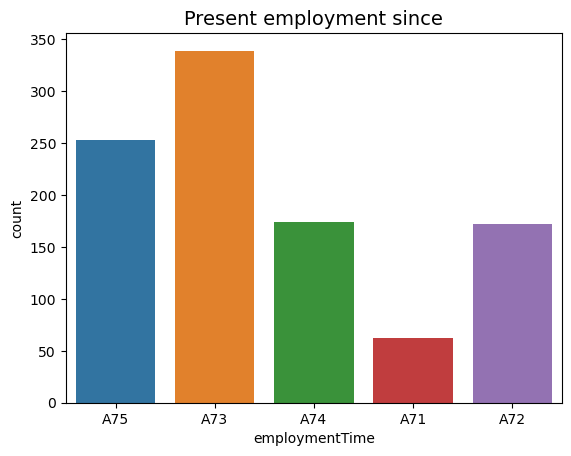

In [29]:
sns.countplot('employmentTime', data=df)
plt.title('Present employment since', fontsize=14)
plt.show()

A71 : unemployed
A72 : ... < 1 year
A73 : 1 <= ... < 4 years
A74 : 4 <= ... < 7 years
A75 : .. >= 7 years

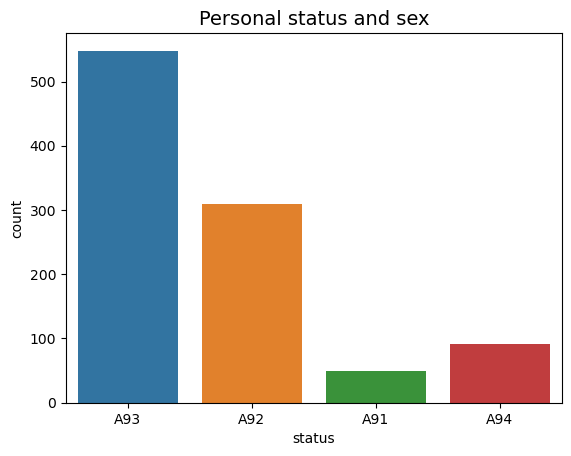

In [30]:
sns.countplot('status', data=df)
plt.title('Personal status and sex', fontsize=14)
plt.show()

A91 : male : divorced/separated
A92 : female : divorced/separated/married
A93 : male : single
A94 : male : married/widowed
A95 : female : single

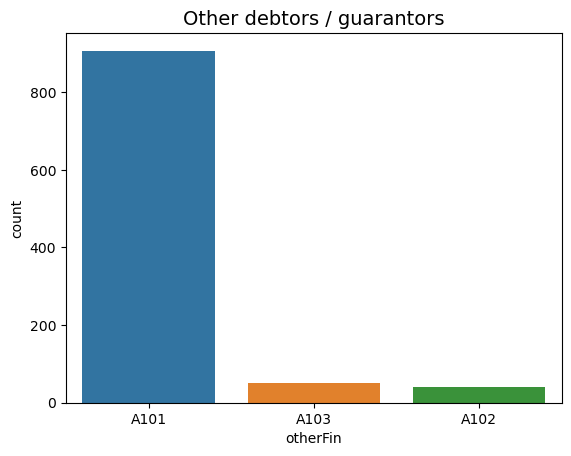

In [31]:
sns.countplot('otherFin', data=df)
plt.title('Other debtors / guarantors', fontsize=14)
plt.show()

A101 : none
A102 : co-applicant
A103 : guarantor

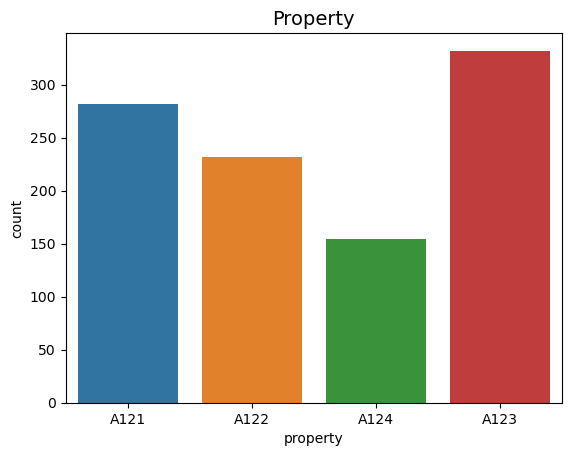

In [32]:
sns.countplot('property', data=df)
plt.title('Property', fontsize=14)
plt.show()

A121 : real estate
A122 : if not A121 : building society savings agreement/ life insurance
A123 : if not A121/A122 : car or other, not in attribute 6
A124 : unknown / no property

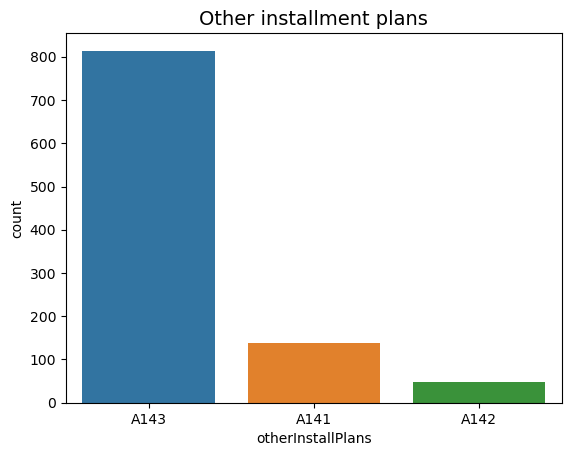

In [33]:
sns.countplot('otherInstallPlans', data=df)
plt.title('Other installment plans', fontsize=14)
plt.show()

A141 : bank
A142 : stores
A143 : none

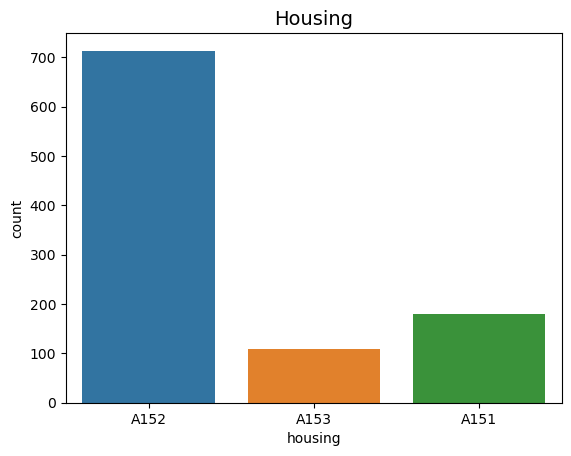

In [34]:
sns.countplot('housing', data=df)
plt.title('Housing', fontsize=14)
plt.show()

A151 : rent
A152 : own
A153 : for free

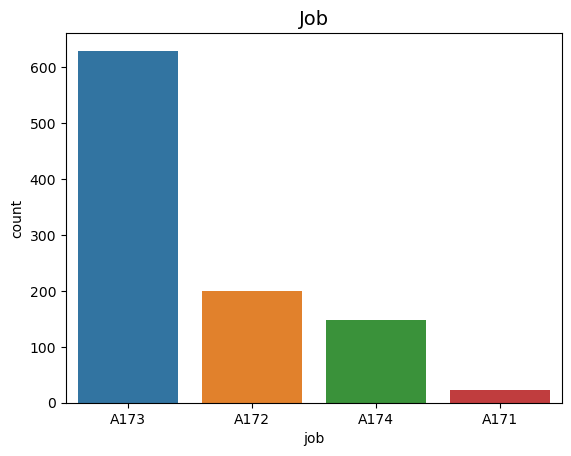

In [35]:
sns.countplot('job', data=df)
plt.title('Job', fontsize=14)
plt.show()

A171 : unemployed/ unskilled - non-resident
A172 : unskilled - resident
A173 : skilled employee / official
A174 : management/ self-employed/highly qualified employee/ officer

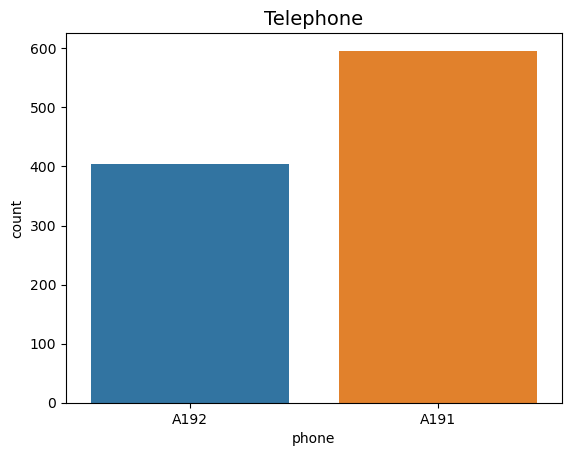

In [36]:
sns.countplot('phone', data=df)
plt.title('Telephone', fontsize=14)
plt.show()

A191 : none
A192 : yes, registered under the customers name

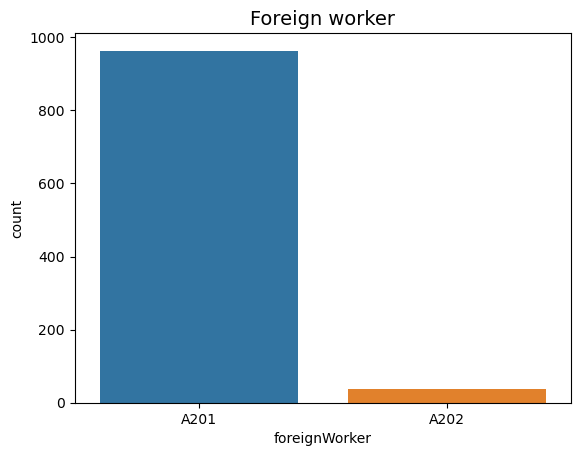

In [37]:
sns.countplot('foreignWorker', data=df)
plt.title('Foreign worker', fontsize=14)
plt.show()

A201 : yes
A202 : no

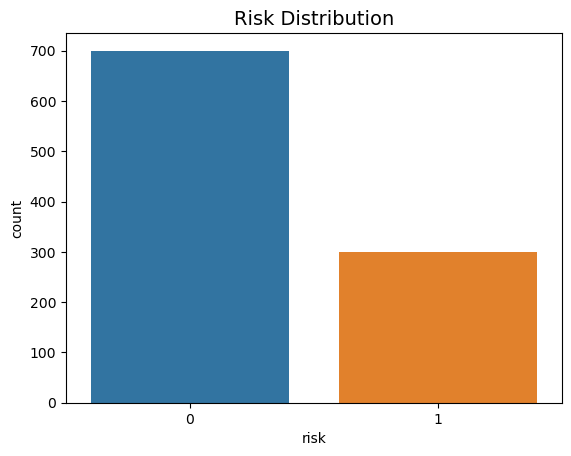

In [38]:
sns.countplot('risk', data=df)
plt.title('Risk Distribution', fontsize=14)
plt.show()

The two categories are not perfectly balanced, as was previously stated. Different strategies can now be chosen. Let's look at outliers and other aspects of the raw data before we tackle this issue.

Distribution and Outliers: German Credit Risk data contains numerous outliers in the numerical attributes. Plot can aid in comprehension:

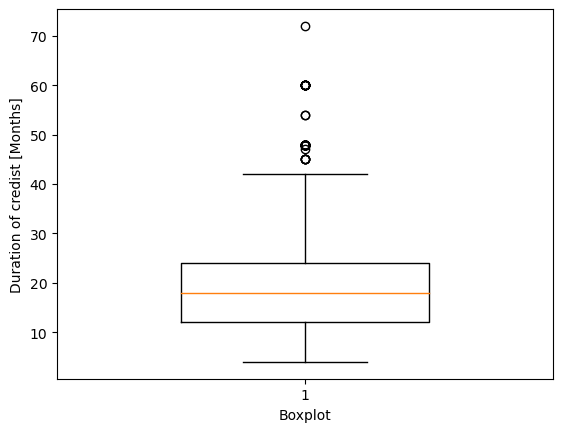

In [39]:
plt.boxplot(df['duration'], widths = 0.5)
plt.ylabel('Duration of credist [Months]')
plt.xlabel('Boxplot')
plt.show()

Although some values are higher than 50, the average credit duration is 20 months. If these values can be relied upon, we can probe further:

In [40]:
df[ df['duration'] > 50]

,checkingAccount,duration,creditHistory,purpose,creditAmount,savingsAcc,employmentTime,installmentPercIncome,status,otherFin,...,property,age,otherInstallPlans,housing,numCredits,job,numOfMant,phone,foreignWorker,risk
29,A11,60,A33,A49,6836,A61,A75,3,A93,A101,...,A124,63,A143,A152,2,A173,1,A192,A201,1
78,A14,54,A30,A41,9436,A65,A73,2,A93,A101,...,A122,39,A143,A152,1,A172,2,A191,A201,0
95,A12,54,A30,A49,15945,A61,A72,3,A93,A101,...,A124,58,A143,A151,1,A173,1,A192,A201,1
134,A14,60,A32,A43,10144,A62,A74,2,A92,A101,...,A121,21,A143,A152,1,A173,1,A192,A201,0
255,A12,60,A33,A43,7418,A65,A73,1,A93,A101,...,A121,27,A143,A152,1,A172,1,A191,A201,0
332,A12,60,A32,A40,7408,A62,A72,4,A92,A101,...,A122,24,A143,A152,1,A174,1,A191,A201,1
373,A14,60,A34,A40,13756,A65,A75,2,A93,A101,...,A124,63,A141,A153,1,A174,1,A192,A201,0
374,A12,60,A31,A410,14782,A62,A75,3,A92,A101,...,A124,60,A141,A153,2,A174,1,A192,A201,1
616,A12,60,A33,A43,9157,A65,A73,2,A93,A101,...,A124,27,A143,A153,1,A174,1,A191,A201,0
637,A14,60,A33,A43,15653,A61,A74,2,A93,A101,...,A123,21,A143,A152,2,A173,1,A192,A201,0


We can see that this data does not exhibit a recurring pattern, thus we have no reason not to believe it.

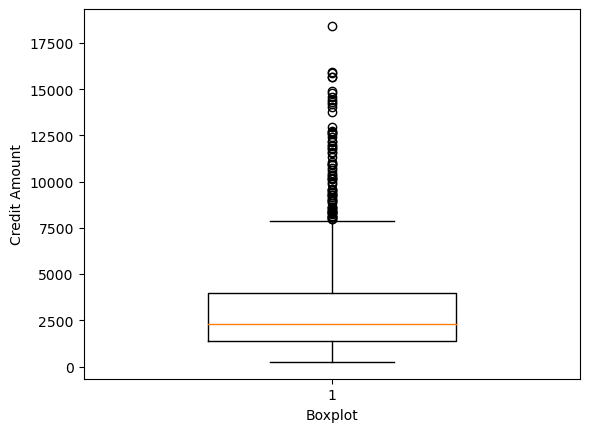

In [41]:
plt.boxplot(df['creditAmount'], widths = 0.5)
plt.ylabel('Credit Amount')
plt.xlabel('Boxplot')
plt.show()

In [42]:
df[ df['creditAmount'] > 7500].set_index(['risk','creditAmount', 'duration']).count(level="risk")

,checkingAccount,creditHistory,purpose,savingsAcc,employmentTime,installmentPercIncome,status,otherFin,timeResidence,property,age,otherInstallPlans,housing,numCredits,job,numOfMant,phone,foreignWorker
risk,,,,,,,,,,,,,,,,,,
0,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
1,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44


Correlations: Starting with the information extracted from the heat map, we wish to do a thorough analysis of it to determine whether some values may be eliminated from the dataset

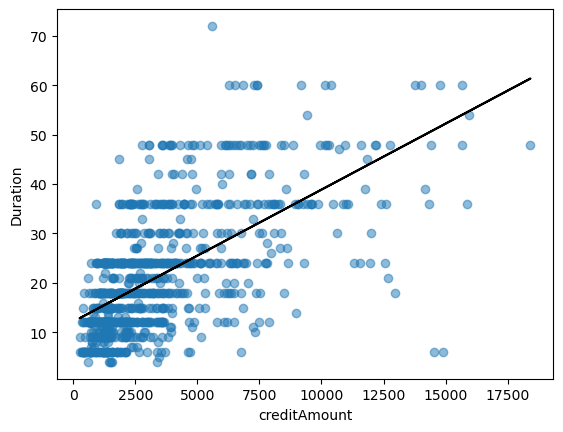

In [43]:
x = df['creditAmount']
y = df['duration']
plt.scatter(x, y, alpha=0.5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"black")
plt.xlabel('creditAmount')
plt.ylabel('Duration')
plt.show()

The quantity of rates and the amount of credit are positively correlated, as would be expected. We cannot, however, eliminate one of the attributes as if the other one adequately represents it because we can observe various elements that have a high variance.

The dataset we utilize now has 7 numerical features and 13 categorical features in addition to the target variable. The other two are nominal values, and the other two are binary values.

Working with the nominal values requires some action. One method is to translate it to a number, with each degree of a category feature corresponding to an integer value. The issue is that numerical values imply an order, yet this is the wrong strategy for our data. One hot encoding is the method most frequently used to solve this issue. We create a new column for each category value and assign 1 to the corresponding value and 0 to all other values. Let's examine what occurs in this instance:

In [44]:
categorical = ['checkingAccount', 'creditHistory', 'purpose', 'savingsAcc', 'employmentTime', 'status', 'otherFin', 'property', 'otherInstallPlans', 'housing', 'job']

In [45]:
Y = df['risk'].copy()
oneHotDF = df.copy()
oneHotDF.drop(['risk'],axis=1, inplace=True)

for att in categorical:
  oneHotDF = pd.concat([oneHotDF,pd.get_dummies(oneHotDF[att], prefix = att)], axis=1)
  oneHotDF .drop([att],axis=1, inplace=True)
oneHotDF

,duration,creditAmount,installmentPercIncome,timeResidence,age,numCredits,numOfMant,phone,foreignWorker,checkingAccount_A11,...,otherInstallPlans_A141,otherInstallPlans_A142,otherInstallPlans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,6,1169,4,4,67,2,1,A192,A201,1,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,A191,A201,0,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,A191,A201,0,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,A191,A201,1,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,A191,A201,1,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,A191,A201,0,...,0,0,1,0,1,0,0,1,0,0
996,30,3857,4,4,40,1,1,A192,A201,1,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,A191,A201,0,...,0,0,1,0,1,0,0,0,1,0
998,45,1845,4,4,23,1,1,A192,A201,1,...,0,0,1,0,0,1,0,0,1,0


0–1 variables can be mapped to binary categorical features:

In [46]:
phoneMapping = {
    'A191' : 1,
    'A192' : 0
}

foreignWorkerMapping = {
    'A202' : 1,
    'A201' : 0
}
oneHotDF['phone'] = oneHotDF['phone'].map(phoneMapping)
oneHotDF['foreignWorker'] = oneHotDF['foreignWorker'].map(foreignWorkerMapping)

In [47]:
oneHotDF

,duration,creditAmount,installmentPercIncome,timeResidence,age,numCredits,numOfMant,phone,foreignWorker,checkingAccount_A11,...,otherInstallPlans_A141,otherInstallPlans_A142,otherInstallPlans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,6,1169,4,4,67,2,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,0,1,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,0,1,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,1,0,0,1,0,0
996,30,3857,4,4,40,1,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
998,45,1845,4,4,23,1,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0


Although the one-hot-encoding process is required, we can see that it resulted in a dataframe with three times as many columns as the original.

PCA: A dimensionality reduction technique called PCA (Principal Components Analysis) is based on the notion of keeping the data's maximum variance while lowering the number of features.

New coordinates are the main component. The expectation is that given data on D variables, the data points will mostly be located in a linear subspace of size d D. The total variance of the data is broken down by the PCs, so the total variance of the original data is equal to the sum of the variances of all the PCs.

The first PCs have a higher variance than the last PCs, which have a lower variance.

Each PC transforms the original data orthogonally linearly.

In [48]:
X_pca = oneHotDF.copy()
# Normalize:
X_pca_norm = (X_pca-X_pca.mean())/X_pca.std()
print("There are " + ("some" if X_pca_norm.isnull().values.any() else "no")  + " null/missing values in the dataset.")

There are no null/missing values in the dataset.


Text(0, 0.5, 'Variance explained')

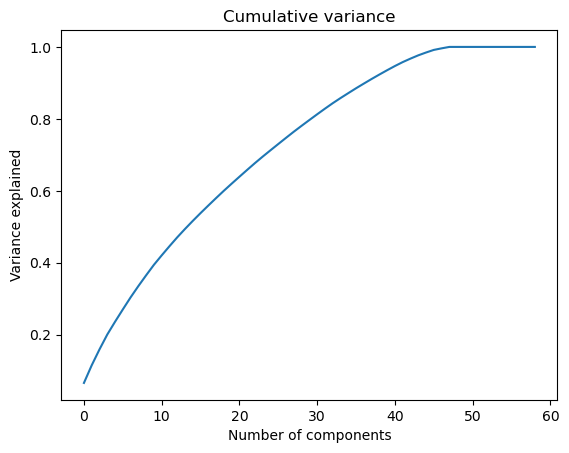

In [49]:
# calculate the principal components
X_pca = PCA(random_state = SEED).fit(X_pca_norm)
cumvar = np.cumsum(X_pca.explained_variance_ratio_)
#Plotting cumulative variance
plt.plot(cumvar)
plt.title('Cumulative variance')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [50]:
cumvar[35]

0.8850792991002363

In [51]:
n_used = 35
X_pca = np.dot(X_pca_norm.values, X_pca.components_[:n_used,:].T)
X_pca = pd.DataFrame(X_pca, columns=["PC%d" % (x + 1) for x in range(n_used)])
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1.082157,-3.197403,1.416799,-2.128576,0.794921,-0.032605,-0.021152,-0.104399,1.391877,-0.485826,...,-0.850239,0.514253,-0.721604,-0.165025,-0.149025,-0.320648,-0.054975,1.363490,-0.330293,-0.844084
1,-2.046062,1.181714,-1.460144,1.090682,0.986275,0.073940,0.824098,0.083795,-0.873888,-1.949324,...,-1.844986,-0.568349,-0.061486,-0.095967,0.726449,-0.173887,0.472890,0.432070,-0.230725,-0.391088
2,0.043917,-2.317239,2.305621,-0.914054,-1.172443,-0.329090,0.427019,-0.464922,-1.435776,0.389333,...,0.688406,1.459506,-0.497424,0.725172,-0.507362,-1.045211,2.010000,1.738597,-0.101321,-0.234409
3,1.187569,2.782986,2.257115,-0.116350,4.270613,1.934985,-0.088762,-0.443202,-1.152752,2.655444,...,-0.143454,-1.016785,0.442327,0.612784,-0.155964,0.221144,-0.315698,0.236581,-0.378430,0.183735
4,3.320006,0.783071,1.719462,-1.520643,0.621341,1.081563,-0.930741,-1.235018,-3.484279,-0.972879,...,-1.299154,0.108081,1.376801,-0.246205,1.513928,0.396242,-1.092485,-0.486634,-0.607261,0.491395


In [52]:
Y.head()

0    0
1    1
2    0
3    0
4    1
Name: risk, dtype: category
Categories (2, int64): [0, 1]

Train and Test set for PCA model:

In [53]:
X, X_test, y, y_test = train_test_split(X_pca, Y, test_size=0.3, stratify = Y)
X_val, X_train, y_val, y_train = train_test_split(X, y, test_size=0.57, stratify = y)

Data Augmentation: Resampling entails transforming the training dataset into a new version where the chosen examples have a different class distribution.

This is a quick and reliable solution to imbalanced classification issues.

The dataset we are examining is not particularly unbalanced; as shown in the following box, the ratio between the two categories is 7:3.

In [54]:
df['risk'].value_counts()

0    700
1    300
Name: risk, dtype: int64

However, it might be interesting to compare the results of various classifiers using the original dataset and a more evenly distributed oversampled dataset.